In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Model for five conduits meeting at a junction and merging into one
from scipy.integrate import odeint
from scipy.optimize import brentq

# Constants - unchanging
rho_w = 1000.#density of water, kg/m^3
rho_i = 900#density of ice, kg/m^3
L_f = 3.34e5#Latent heat of fusion (ice), J/kg
n=3.#ice flow law exponent, unitless
B=5.8e7#Arrhenius parameter, N/m^2 *s^(1/n)
f=0.1#Darcy-Weisbach friction factor, unitless
g = 9.8#gravitational accel, m^2/s
P = 24.*3600. # Period - 1 day in seconds

In [3]:
# Functions
def R(ti,Ri):
    P=24.*3600.
    return Ri*(1.+sin(2.*pi*ti/P)/2.)

def P_wet(A):
    return 2.*sqrt(pi*A)#2.*A**2./pi
def D_H(A):
    return 4.*A/P_wet(A)

def C(A,L):
    return A*sqrt(2.*g/(1+f*L/D_H(A)))

# calculate head for 5 conduits
def fhf(hf, h1, C1,C2,C3,C4,C5,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-hf))*sign(h1-hf) + C2*sqrt(abs(h1-hf))*sign(h1-hf) + C3*sqrt(abs(h1-hf))*sign(h1-hf) + C4*sqrt(abs(h1-hf))*sign(h1-hf) + C5*sqrt(abs(h1-hf))*sign(h1-hf) - C_merg*sqrt(hf)

# 5 conduits
def dy_dt5(y,ti,Recharge,Zi,A_R,L1,L2,L3,L4,L5,L_merg):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A5 = y[5]
    A_merg = y[6]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C5 = C(A5,L5)
    C_merg = C(A_merg,L_merg)
    hf = brentq(fhf, 0,10000, args=(h1,C1,C2,C3,C4,C5,C_merg))
    Q1 = C1*sqrt(abs(h1-hf))*sign(h1-hf)
    Q2 = C2*sqrt(abs(h1-hf))*sign(h1-hf)
    Q3 = C3*sqrt(abs(h1-hf))*sign(h1-hf)
    Q4 = C4*sqrt(abs(h1-hf))*sign(h1-hf)
    Q5 = C5*sqrt(abs(h1-hf))*sign(h1-hf)
    Q_merg = C_merg*sqrt(abs(hf))
    P = 24.*3600.
    dh1_dt = (Recharge*(1.+sin(2.*pi*ti/P)/2.)-Q1-Q2-Q3-Q4-Q5)/A_R
    Pw1 = rho_w*g*(h1+hf)/2.
    Pw2 = rho_w*g*(h1+hf)/2.
    Pw3 = rho_w*g*(h1+hf)/2.
    Pw4 = rho_w*g*(h1+hf)/2.
    Pw5 = rho_w*g*(h1+hf)/2.
    Pw_merg = rho_w*g*(hf)
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw1)*abs(Pi-Pw1)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw2)*abs(Pi-Pw2)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw3)*abs(Pi-Pw3)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw4)*abs(Pi-Pw4)**(n-1.)
    dA5_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A5)*(abs(Q5)/A5)**3 - 2.*(1./(n*B))**n*A5*(Pi-Pw5)*abs(Pi-Pw5)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dA5_dt, dAmerg_dt]




Max Head = 250.0 Min Head = 32.812438124
Average Recharge = 2.5 Moulin Area = 100 Ice thickness = 500


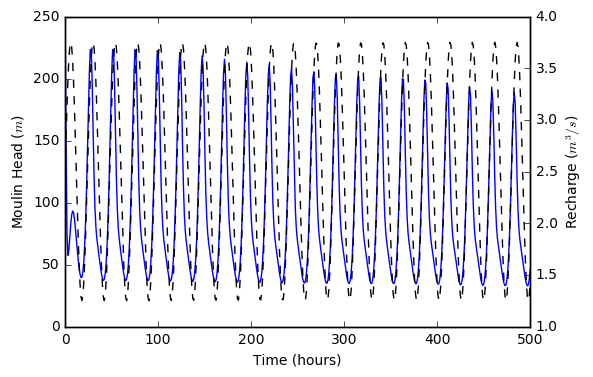

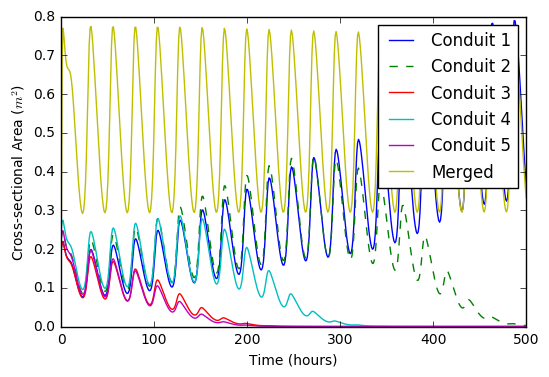

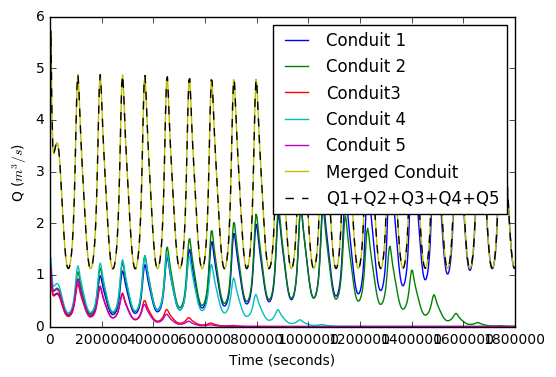

In [32]:
# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 5 conduit below --------
L1=500 # Length of conduit 1
L2=510 # Length of conduit 2
L3=510 # Length of conduit 3
L4=520
L5=525
L_merg=100 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.2256 # Starting Ac of conduit 2
A0_3=0.2 # Starting Ac of conduit 3
A0_4=0.25
A0_5=0.227
A0_merg=0.23 # Starting Ac of merged conduit
h0=250 # head in moulin (start)
Recharge=2.5 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=500 # Ice thickness


# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol5= odeint(dy_dt5, [h0,A0_1,A0_2,A0_3,A0_4,A0_5,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L3,L4,L5,L_merg))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol5[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol5[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol5[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol5[:,1])
plot(tplot,sol5[:,2],'--')
plot(tplot,sol5[:,3])
plot(tplot,sol5[:,4])
plot(tplot,sol5[:,5])
plot(tplot,sol5[:,6])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['Conduit 1','Conduit 2','Conduit 3','Conduit 4','Conduit 5','Merged'],loc=1)

# CHECK -----
C1 = C(sol5[:,1],L1)
C2 = C(sol5[:,2],L2)
C3 = C(sol5[:,3],L3)
C4 = C(sol5[:,4],L4)
C5 = C(sol5[:,5],L5)
C_merg = C(sol5[:,6],L_merg)
hf = []
for i,Cblank in enumerate(C1):
    hf.append(brentq(fhf, 0, 10000, args=(sol5[i,0],C1[i],C2[i],C3[i],C4[i],C5[i],C_merg[i])))
Q1 = C1*sqrt(abs(sol5[:,0]-hf))*sign(sol5[:,0]-hf)
Q2 = C2*sqrt(abs(sol5[:,0]-hf))*sign(sol5[:,0]-hf)
Q3 = C3*sqrt(abs(sol5[:,0]-hf))*sign(sol5[:,0]-hf)
Q4 = C4*sqrt(abs(sol5[:,0]-hf))*sign(sol5[:,0]-hf)
Q5 = C5*sqrt(abs(sol5[:,0]-hf))*sign(sol5[:,0]-hf)
Q_merg = C_merg*sqrt(array(hf))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q5,t,Q_merg,t,Q1+Q2+Q3+Q4+Q5,'--')
legend(['Conduit 1','Conduit 2','Conduit3','Conduit 4','Conduit 5','Merged Conduit','Q1+Q2+Q3+Q4+Q5'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol5

Max Head = 911.466502355 Min Head = 557.375675532
Average Recharge = 1.0 Moulin Area = 100 Ice thickness = 1000


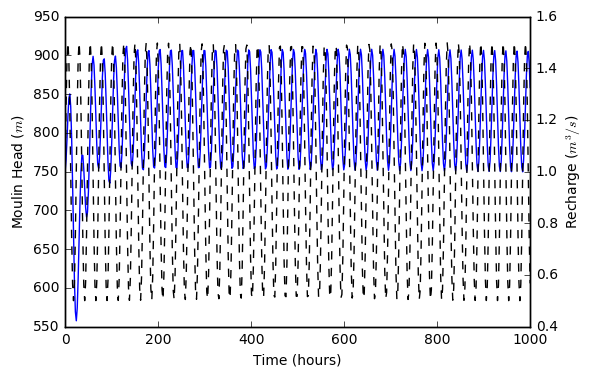

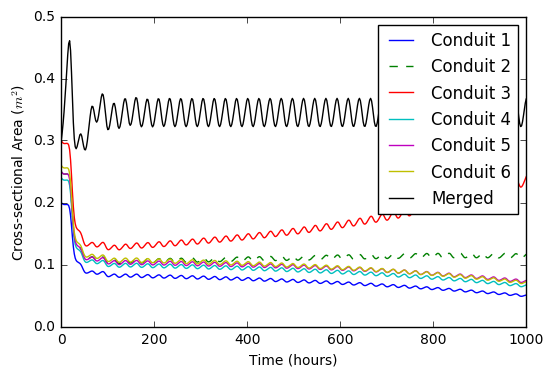

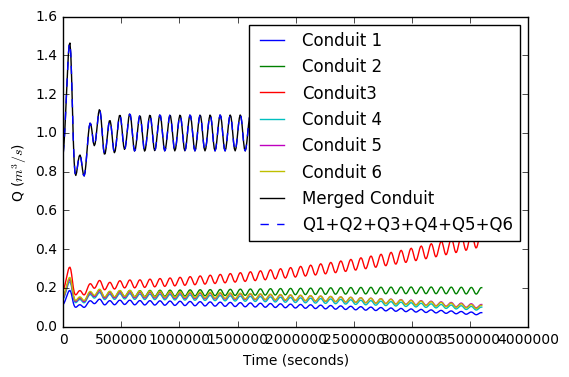

In [20]:
# calculate head for six conduits
def fh6(h6, h1, C1,C2,C3,C4,C5,C6,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-h6))*sign(h1-h6) + C2*sqrt(abs(h1-h6))*sign(h1-h6) + C3*sqrt(abs(h1-h6))*sign(h1-h6) + C4*sqrt(abs(h1-h6))*sign(h1-h6) + C5*sqrt(abs(h1-h6))*sign(h1-h6)+ C6*sqrt(abs(h1-h6))*sign(h1-h6) - C_merg*sqrt(h6)

# six conduits
def dy_dt6(y,ti,Recharge,Zi,A_R,L1,L2,L3,L4,L5,L6,L_merg):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A5 = y[5]
    A6 = y[6]
    A_merg = y[7]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C5 = C(A5,L5)
    C6 = C(A6,L6)
    C_merg = C(A_merg,L_merg)
    h6 = brentq(fh6, 0,10000, args=(h1,C1,C2,C3,C4,C5,C6,C_merg))
    Q1 = C1*sqrt(abs(h1-h6))*sign(h1-h6)
    Q2 = C2*sqrt(abs(h1-h6))*sign(h1-h6)
    Q3 = C3*sqrt(abs(h1-h6))*sign(h1-h6)
    Q4 = C4*sqrt(abs(h1-h6))*sign(h1-h6)
    Q5 = C5*sqrt(abs(h1-h6))*sign(h1-h6)
    Q6 = C6*sqrt(abs(h1-h6))*sign(h1-h6)
    Q_merg = C_merg*sqrt(abs(h6))
    P = 24.*3600.
    dh1_dt = (Recharge*(1.+sin(2.*pi*ti/P)/2.)-Q1-Q2-Q3-Q4-Q5-Q6)/A_R
    Pw1 = rho_w*g*(h1+h6)/2.
    Pw2 = rho_w*g*(h1+h6)/2.
    Pw3 = rho_w*g*(h1+h6)/2.
    Pw4 = rho_w*g*(h1+h6)/2.
    Pw5 = rho_w*g*(h1+h6)/2.
    Pw6 = rho_w*g*(h1+h6)/2.
    Pw_merg = rho_w*g*(h6)
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw1)*abs(Pi-Pw1)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw2)*abs(Pi-Pw2)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw3)*abs(Pi-Pw3)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw4)*abs(Pi-Pw4)**(n-1.)
    dA5_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A5)*(abs(Q5)/A5)**3 - 2.*(1./(n*B))**n*A5*(Pi-Pw5)*abs(Pi-Pw5)**(n-1.)
    dA6_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A6)*(abs(Q6)/A6)**3 - 2.*(1./(n*B))**n*A6*(Pi-Pw6)*abs(Pi-Pw6)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dA5_dt, dA6_dt, dAmerg_dt]


# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=5000 # Length of conduit 1
L2=5050 # Length of conduit 2
L3=5100 # Length of conduit 3
L4=5130
L5=5150
L6=5200
L_merg=10000 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.25 # Starting Ac of conduit 2
A0_3=0.3 # Starting Ac of conduit 3
A0_4=0.24
A0_5=0.25
A0_6=0.26
A0_merg=0.3 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 1000
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol6= odeint(dy_dt6, [h0,A0_1,A0_2,A0_3,A0_4,A0_5,A0_6,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L3,L4,L5,L6,L_merg))
#adj=linspace(0.8,1,500)
Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol6[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol6[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol6[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol6[:,1])
plot(tplot,sol6[:,2],'--')
plot(tplot,sol6[:,3])
plot(tplot,sol6[:,4])
plot(tplot,sol6[:,5])
plot(tplot,sol6[:,6])
plot(tplot,sol6[:,7])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['Conduit 1','Conduit 2','Conduit 3','Conduit 4','Conduit 5','Conduit 6','Merged'],loc=1)

# CHECK -----
C1 = C(sol6[:,1],L1)
C2 = C(sol6[:,2],L2)
C3 = C(sol6[:,3],L3)
C4 = C(sol6[:,4],L4)
C5 = C(sol6[:,5],L5)
C6 = C(sol6[:,6],L6)
C_merg = C(sol6[:,7],L_merg)
h6 = []
for i,Cblank in enumerate(C1):
    h6.append(brentq(fh6, 0, 10000, args=(sol6[i,0],C1[i],C2[i],C3[i],C4[i],C5[i],C6[i],C_merg[i])))
Q1 = C1*sqrt(abs(sol6[:,0]-h6))*sign(sol6[:,0]-h6)
Q2 = C2*sqrt(abs(sol6[:,0]-h6))*sign(sol6[:,0]-h6)
Q3 = C3*sqrt(abs(sol6[:,0]-h6))*sign(sol6[:,0]-h6)
Q4 = C4*sqrt(abs(sol6[:,0]-h6))*sign(sol6[:,0]-h6)
Q5 = C5*sqrt(abs(sol6[:,0]-h6))*sign(sol6[:,0]-h6)
Q6 = C6*sqrt(abs(sol6[:,0]-h6))*sign(sol6[:,0]-h6)
Q_merg = C_merg*sqrt(array(h6))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q5,t,Q6,t,Q_merg,t,Q1+Q2+Q3+Q4+Q5+Q6,'--')
legend(['Conduit 1','Conduit 2','Conduit3','Conduit 4','Conduit 5','Conduit 6','Merged Conduit','Q1+Q2+Q3+Q4+Q5+Q6'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol6

Help on function linspace in module numpy.core.function_base:

linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
    Return evenly spaced numbers over a specified interval.
    
    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].
    
    The endpoint of the interval can optionally be excluded.
    
    Parameters
    ----------
    start : scalar
        The starting value of the sequence.
    stop : scalar
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that `stop` is excluded.  Note that the step
        size changes when `endpoint` is False.
    num : int, optional
        Number of samples to generate. Default is 50. Must be non-negative.
    endpoint : bool, optional
        If True, `stop` is the last sample. Otherwise, it is not included.
        Default is True.
    retstep : bo

Max Head = 913.505731605 Min Head = 532.866038859
Average Recharge = 1.0 Moulin Area = 100 Ice thickness = 1000


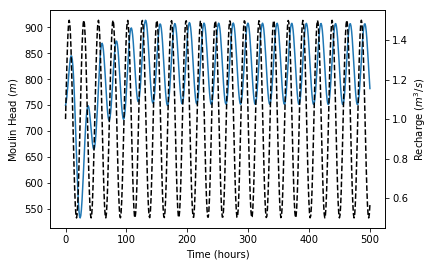

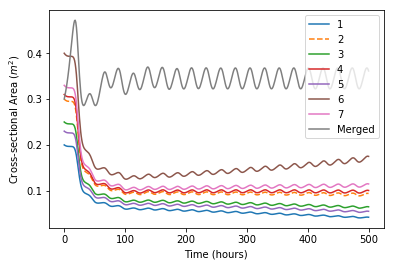

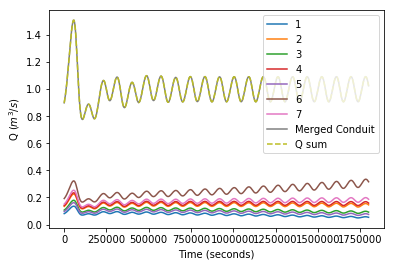

In [11]:
# calculate head for seven conduits
def fh7(h7, h1, C1,C2,C3,C4,C5,C6,C7,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-h7))*sign(h1-h7) + C2*sqrt(abs(h1-h7))*sign(h1-h7) + C3*sqrt(abs(h1-h7))*sign(h1-h7) + C4*sqrt(abs(h1-h7))*sign(h1-h7) + C5*sqrt(abs(h1-h7))*sign(h1-h7)+ C6*sqrt(abs(h1-h7))*sign(h1-h7)+ C7*sqrt(abs(h1-h7))*sign(h1-h7) - C_merg*sqrt(h7)

# six conduits
def dy_dt7(y,ti,Recharge,Zi,A_R,L1,L2,L3,L4,L5,L6,L7,L_merg):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A5 = y[5]
    A6 = y[6]
    A7 = y[7]
    A_merg = y[8]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C5 = C(A5,L5)
    C6 = C(A6,L6)
    C7 = C(A7,L7)
    C_merg = C(A_merg,L_merg)
    h7 = brentq(fh7, 0,10000, args=(h1,C1,C2,C3,C4,C5,C6,C7,C_merg))
    hfunction = sqrt(abs(h1-h7))*sign(h1-h7)
    Q1 = C1*hfunction
    Q2 = C2*hfunction
    Q3 = C3*hfunction
    Q4 = C4*hfunction
    Q5 = C5*hfunction
    Q6 = C6*hfunction
    Q7 = C7*hfunction
    Q_merg = C_merg*sqrt(abs(h7))
    P = 24.*3600.
    dh1_dt = (R(ti,Recharge)-Q1-Q2-Q3-Q4-Q5-Q6-Q7)/A_R
    Pw = rho_w*g*(h1+h7)/2.
    Pw_merg = rho_w*g*(h7) 
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA5_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A5)*(abs(Q5)/A5)**3 - 2.*(1./(n*B))**n*A5*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA6_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A6)*(abs(Q6)/A6)**3 - 2.*(1./(n*B))**n*A6*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA7_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A7)*(abs(Q7)/A7)**3 - 2.*(1./(n*B))**n*A7*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dA5_dt, dA6_dt, dA7_dt, dAmerg_dt]


# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=5000 # Length of conduit 1
L2=5000 # Length of conduit 2
L3=5000 # Length of conduit 3
L4=5000
L5=5000
L6=5000
L7=5000
L_merg=10000 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.3 # Starting Ac of conduit 2
A0_3=0.25 # Starting Ac of conduit 3
A0_4=0.31
A0_5=0.23
A0_6=0.4
A0_7=0.33
A0_merg=0.3 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol7= odeint(dy_dt7, [h0,A0_1,A0_2,A0_3,A0_4,A0_5,A0_6,A0_7,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L3,L4,L5,L6,L7,L_merg))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol7[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol7[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol7[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol7[:,1])
plot(tplot,sol7[:,2],'--')
plot(tplot,sol7[:,3])
plot(tplot,sol7[:,4])
plot(tplot,sol7[:,5])
plot(tplot,sol7[:,6])
plot(tplot,sol7[:,7])
plot(tplot,sol7[:,8])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['1','2','3','4','5','6','7','Merged'],loc=1)

# CHECK -----
C1 = C(sol7[:,1],L1)
C2 = C(sol7[:,2],L2)
C3 = C(sol7[:,3],L3)
C4 = C(sol7[:,4],L4)
C5 = C(sol7[:,5],L5)
C6 = C(sol7[:,6],L6)
C7 = C(sol7[:,7],L7)
C_merg = C(sol7[:,8],L_merg)
h7 = []
for i,Cblank in enumerate(C1):
    h7.append(brentq(fh7, 0, 10000, args=(sol7[i,0],C1[i],C2[i],C3[i],C4[i],C5[i],C6[i],C7[i],C_merg[i])))
hfun=sqrt(abs(sol7[:,0]-h7))*sign(sol7[:,0]-h7)
Q1 = C1*hfun
Q2 = C2*hfun
Q3 = C3*hfun
Q4 = C4*hfun
Q5 = C5*hfun
Q6 = C6*hfun
Q7 = C7*hfun
Q_merg = C_merg*sqrt(array(h7))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q5,t,Q6,t,Q7,t,Q_merg,t,Q1+Q2+Q3+Q4+Q5+Q6+Q7,'--')
legend(['1','2','3','4','5','6','7','Merged Conduit','Q sum'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol7

Max Head = 915.529918983 Min Head = 524.104693164
Average Recharge = 1.0 Moulin Area = 100 Ice thickness = 1000


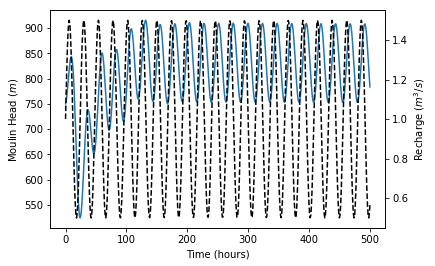

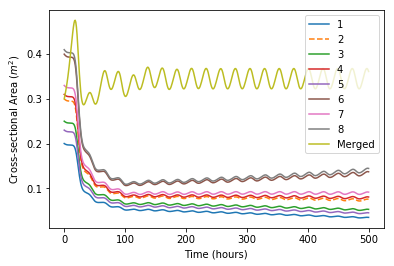

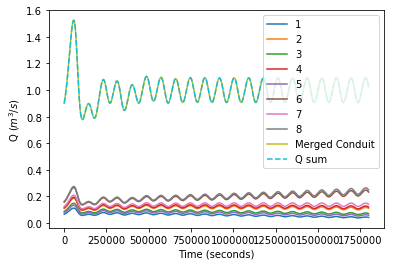

In [15]:
# calculate head for eight conduits
def fh8(h7, h1, C1,C2,C3,C4,C5,C6,C7,C8,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-h7))*sign(h1-h7) + C2*sqrt(abs(h1-h7))*sign(h1-h7) + C3*sqrt(abs(h1-h7))*sign(h1-h7) + C4*sqrt(abs(h1-h7))*sign(h1-h7) + C5*sqrt(abs(h1-h7))*sign(h1-h7)+ C6*sqrt(abs(h1-h7))*sign(h1-h7)+ C7*sqrt(abs(h1-h7))*sign(h1-h7)+ C8*sqrt(abs(h1-h7))*sign(h1-h7) - C_merg*sqrt(h7)

# eight conduits
def dy_dt8(y,ti,Recharge,Zi,A_R,L1,L2,L3,L4,L5,L6,L7,L8,L_merg):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A5 = y[5]
    A6 = y[6]
    A7 = y[7]
    A8 = y[8]
    A_merg = y[9]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C5 = C(A5,L5)
    C6 = C(A6,L6)
    C7 = C(A7,L7)
    C8 = C(A8,L8)
    C_merg = C(A_merg,L_merg)
    h8 = brentq(fh8, 0,10000, args=(h1,C1,C2,C3,C4,C5,C6,C7,C8,C_merg))
    hfunction = sqrt(abs(h1-h8))*sign(h1-h8)
    Q1 = C1*hfunction
    Q2 = C2*hfunction
    Q3 = C3*hfunction
    Q4 = C4*hfunction
    Q5 = C5*hfunction
    Q6 = C6*hfunction
    Q7 = C7*hfunction
    Q8 = C8*hfunction
    Q_merg = C_merg*sqrt(abs(h8))
    dh1_dt = (R(ti,Recharge)-Q1-Q2-Q3-Q4-Q5-Q6-Q7-Q8)/A_R
    Pw = rho_w*g*(h1+h8)/2.
    Pw_merg = rho_w*g*(h8) 
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA5_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A5)*(abs(Q5)/A5)**3 - 2.*(1./(n*B))**n*A5*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA6_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A6)*(abs(Q6)/A6)**3 - 2.*(1./(n*B))**n*A6*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA7_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A7)*(abs(Q7)/A7)**3 - 2.*(1./(n*B))**n*A7*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA8_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A8)*(abs(Q8)/A8)**3 - 2.*(1./(n*B))**n*A8*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dA5_dt, dA6_dt, dA7_dt, dA8_dt, dAmerg_dt]


# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=5000 # Length of conduit 1
L2=5000 # Length of conduit 2
L3=5000 # Length of conduit 3
L4=5000
L5=5000
L6=5000
L7=5000
L8=5000
L_merg=10000 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.3 # Starting Ac of conduit 2
A0_3=0.25 # Starting Ac of conduit 3
A0_4=0.31
A0_5=0.23
A0_6=0.4
A0_7=0.33
A0_8=0.41
A0_merg=0.3 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol8= odeint(dy_dt8, [h0,A0_1,A0_2,A0_3,A0_4,A0_5,A0_6,A0_7,A0_8,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L3,L4,L5,L6,L7,L8,L_merg))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol8[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol8[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol8[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol8[:,1])
plot(tplot,sol8[:,2],'--')
plot(tplot,sol8[:,3])
plot(tplot,sol8[:,4])
plot(tplot,sol8[:,5])
plot(tplot,sol8[:,6])
plot(tplot,sol8[:,7])
plot(tplot,sol8[:,8])
plot(tplot,sol8[:,9])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['1','2','3','4','5','6','7','8','Merged'],loc=1)

# CHECK -----
C1 = C(sol8[:,1],L1)
C2 = C(sol8[:,2],L2)
C3 = C(sol8[:,3],L3)
C4 = C(sol8[:,4],L4)
C5 = C(sol8[:,5],L5)
C6 = C(sol8[:,6],L6)
C7 = C(sol8[:,7],L7)
C8 = C(sol8[:,8],L8)

C_merg = C(sol8[:,9],L_merg)
h8 = []
for i,Cblank in enumerate(C1):
    h8.append(brentq(fh8, 0, 10000, args=(sol8[i,0],C1[i],C2[i],C3[i],C4[i],C5[i],C6[i],C7[i],C8[i],C_merg[i])))
hfun=sqrt(abs(sol8[:,0]-h8))*sign(sol8[:,0]-h8)
Q1 = C1*hfun
Q2 = C2*hfun
Q3 = C3*hfun
Q4 = C4*hfun
Q5 = C5*hfun
Q6 = C6*hfun
Q7 = C7*hfun
Q8 = C8*hfun
Q_merg = C_merg*sqrt(array(h8))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q5,t,Q6,t,Q7,t,Q8,t,Q_merg,t,Q1+Q2+Q3+Q4+Q5+Q6+Q7+Q8,'--')
legend(['1','2','3','4','5','6','7','8','Merged Conduit','Q sum'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol8

Max Head = 796.813179526 Min Head = 14.4236654944
Average Recharge = 2.5 Moulin Area = 100 Ice thickness = 1000


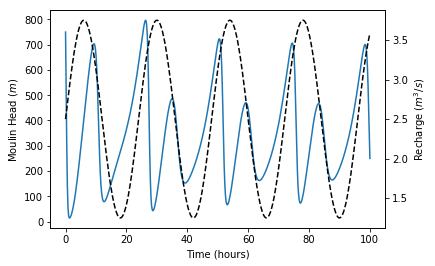

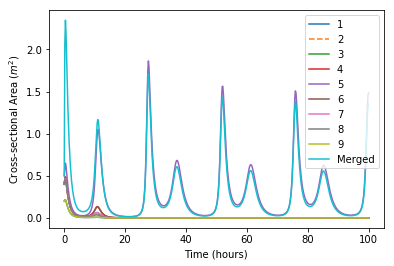

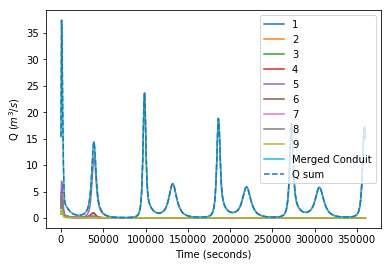

In [16]:
# calculate head for eight conduits
def fh9(hf, h1, C1,C2,C3,C4,C5,C6,C7,C8,C9,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-hf))*sign(h1-hf) + C2*sqrt(abs(h1-hf))*sign(h1-hf) + C3*sqrt(abs(h1-hf))*sign(h1-hf) + C4*sqrt(abs(h1-hf))*sign(h1-hf) + C5*sqrt(abs(h1-hf))*sign(h1-hf)+ C6*sqrt(abs(h1-hf))*sign(h1-hf)+ C7*sqrt(abs(h1-hf))*sign(h1-hf)+ C8*sqrt(abs(h1-hf))*sign(h1-hf)+ C9*sqrt(abs(h1-hf))*sign(h1-hf) - C_merg*sqrt(hf)

# eight conduits
def dy_dt9(y,ti,Recharge,Zi,A_R,L1,L2,L3,L4,L5,L6,L7,L8,L9,L_merg):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A5 = y[5]
    A6 = y[6]
    A7 = y[7]
    A8 = y[8]
    A9 = y[9]
    A_merg = y[10]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C5 = C(A5,L5)
    C6 = C(A6,L6)
    C7 = C(A7,L7)
    C8 = C(A8,L8)
    C9 = C(A9,L9)
    C_merg = C(A_merg,L_merg)
    h9 = brentq(fh9, 0,10000, args=(h1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C_merg))
    hfunction = sqrt(abs(h1-h9))*sign(h1-h9)
    Q1 = C1*hfunction
    Q2 = C2*hfunction
    Q3 = C3*hfunction
    Q4 = C4*hfunction
    Q5 = C5*hfunction
    Q6 = C6*hfunction
    Q7 = C7*hfunction
    Q8 = C8*hfunction
    Q9 = C9*hfunction
    Q_merg = C_merg*sqrt(abs(h9))
    dh1_dt = (R(ti,Recharge)-Q1-Q2-Q3-Q4-Q5-Q6-Q7-Q8-Q9)/A_R
    Pw = rho_w*g*(h1+h9)/2.
    Pw_merg = rho_w*g*(h9) 
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA5_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A5)*(abs(Q5)/A5)**3 - 2.*(1./(n*B))**n*A5*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA6_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A6)*(abs(Q6)/A6)**3 - 2.*(1./(n*B))**n*A6*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA7_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A7)*(abs(Q7)/A7)**3 - 2.*(1./(n*B))**n*A7*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA8_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A8)*(abs(Q8)/A8)**3 - 2.*(1./(n*B))**n*A8*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA9_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A9)*(abs(Q9)/A9)**3 - 2.*(1./(n*B))**n*A9*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dA5_dt, dA6_dt, dA7_dt, dA8_dt, dA9_dt, dAmerg_dt]


# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=700 # Length of conduit 1
L2=650 # Length of conduit 2
L3=600 # Length of conduit 3
L4=550
L5=500
L6=550
L7=600
L8=650
L9=700
L_merg=100 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.4 # Starting Ac of conduit 2
A0_3=0.4 # Starting Ac of conduit 3
A0_4=0.4
A0_5=0.5
A0_6=0.4
A0_7=0.4
A0_8=0.4
A0_9=0.2
A0_merg=0.5 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=2.5 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 100
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol9= odeint(dy_dt9, [h0,A0_1,A0_2,A0_3,A0_4,A0_5,A0_6,A0_7,A0_8,A0_9,A0_merg], t, args=(Recharge,Z,A_R,L1,L2,L3,L4,L5,L6,L7,L8,L9,L_merg))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol9[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol9[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol9[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol9[:,1])
plot(tplot,sol9[:,2],'--')
plot(tplot,sol9[:,3])
plot(tplot,sol9[:,4])
plot(tplot,sol9[:,5])
plot(tplot,sol9[:,6])
plot(tplot,sol9[:,7])
plot(tplot,sol9[:,8])
plot(tplot,sol9[:,9])
plot(tplot,sol9[:,10])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['1','2','3','4','5','6','7','8','9','Merged'],loc=1)

# CHECK -----
C1 = C(sol9[:,1],L1)
C2 = C(sol9[:,2],L2)
C3 = C(sol9[:,3],L3)
C4 = C(sol9[:,4],L4)
C5 = C(sol9[:,5],L5)
C6 = C(sol9[:,6],L6)
C7 = C(sol9[:,7],L7)
C8 = C(sol9[:,8],L8)
C9 = C(sol9[:,9],L9)
C_merg = C(sol9[:,10],L_merg)
h9 = []
for i,Cblank in enumerate(C1):
    h9.append(brentq(fh9, 0, 10000, args=(sol9[i,0],C1[i],C2[i],C3[i],C4[i],C5[i],C6[i],C7[i],C8[i],C9[i],C_merg[i])))
hfun=sqrt(abs(sol9[:,0]-h9))*sign(sol9[:,0]-h9)
Q1 = C1*hfun
Q2 = C2*hfun
Q3 = C3*hfun
Q4 = C4*hfun
Q5 = C5*hfun
Q6 = C6*hfun
Q7 = C7*hfun
Q8 = C8*hfun
Q9 = C9*hfun
Q_merg = C_merg*sqrt(array(h9))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q5,t,Q6,t,Q7,t,Q8,t,Q9,t,Q_merg,t,Q1+Q2+Q3+Q4+Q5+Q6+Q7+Q8+Q9,'--')
legend(['1','2','3','4','5','6','7','8','9','Merged Conduit','Q sum'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol9

# calculate head for ten conduits
def fh10(hf, h1, C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C_merg):
    #flow conservation at junction, used to calculate hf via minimization
    return C1*sqrt(abs(h1-hf))*sign(h1-hf) + C2*sqrt(abs(h1-hf))*sign(h1-hf) + C3*sqrt(abs(h1-hf))*sign(h1-hf) + C4*sqrt(abs(h1-hf))*sign(h1-hf) + C5*sqrt(abs(h1-hf))*sign(h1-hf)+ C6*sqrt(abs(h1-hf))*sign(h1-hf)+ C7*sqrt(abs(h1-hf))*sign(h1-hf)+ C8*sqrt(abs(h1-hf))*sign(h1-hf)+ C9*sqrt(abs(h1-hf))*sign(h1-hf)+ C10*sqrt(abs(h1-hf))*sign(h1-hf) - C_merg*sqrt(hf)

# ten conduits
def dy_dt10(y,ti,Recharge,Zi):
    Pi = rho_i*g*Zi
    h1 = y[0]
    A1 = y[1]
    A2 = y[2]
    A3 = y[3]
    A4 = y[4]
    A5 = y[5]
    A6 = y[6]
    A7 = y[7]
    A8 = y[8]
    A9 = y[9]
    A10 = y[10]
    A_merg = y[11]
    C1 = C(A1,L1)
    C2 = C(A2,L2)
    C3 = C(A3,L3)
    C4 = C(A4,L4)
    C5 = C(A5,L5)
    C6 = C(A6,L6)
    C7 = C(A7,L7)
    C8 = C(A8,L8)
    C9 = C(A9,L9)
    C10=C(A10,L10)
    C_merg = C(A_merg,L_merg)
    h10 = brentq(fh10, 0,10000, args=(h1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C_merg))
    hfunction = sqrt(abs(h1-h10))*sign(h1-h10)
    Q1 = C1*hfunction
    Q2 = C2*hfunction
    Q3 = C3*hfunction
    Q4 = C4*hfunction
    Q5 = C5*hfunction
    Q6 = C6*hfunction
    Q7 = C7*hfunction
    Q8 = C8*hfunction
    Q9 = C9*hfunction
    Q10=C10*hfunction
    Q_merg = C_merg*sqrt(abs(h10))
    dh1_dt = (R(ti,Recharge)-Q1-Q2-Q3-Q4-Q5-Q6-Q7-Q8-Q9-Q10)/A_R
    Pw = rho_w*g*(h1+h10)/2.
    Pw_merg = rho_w*g*(h10) 
    dA1_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A1)*(abs(Q1)/A1)**3 - 2.*(1./(n*B))**n*A1*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA2_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A2)*(abs(Q2)/A2)**3 - 2.*(1./(n*B))**n*A2*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA3_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A3)*(abs(Q3)/A3)**3 - 2.*(1./(n*B))**n*A3*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA4_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A4)*(abs(Q4)/A4)**3 - 2.*(1./(n*B))**n*A4*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA5_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A5)*(abs(Q5)/A5)**3 - 2.*(1./(n*B))**n*A5*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA6_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A6)*(abs(Q6)/A6)**3 - 2.*(1./(n*B))**n*A6*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA7_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A7)*(abs(Q7)/A7)**3 - 2.*(1./(n*B))**n*A7*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA8_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A8)*(abs(Q8)/A8)**3 - 2.*(1./(n*B))**n*A8*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA9_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A9)*(abs(Q9)/A9)**3 - 2.*(1./(n*B))**n*A9*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dA10_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A10)*(abs(Q10)/A10)**3 - 2.*(1./(n*B))**n*A10*(Pi-Pw)*abs(Pi-Pw)**(n-1.)
    dAmerg_dt = f*rho_w/(8*rho_i*L_f)*P_wet(A_merg)*(abs(Q_merg)/A_merg)**3 - 2.*(1./(n*B))**n*A_merg*(Pi-Pw_merg)*abs(Pi-Pw_merg)**(n-1.)
    return [dh1_dt, dA1_dt, dA2_dt, dA3_dt, dA4_dt, dA5_dt, dA6_dt, dA7_dt, dA8_dt, dA9_dt, dA10_dt, dAmerg_dt]


# Investigating: minimum hydraulic diameter neccessary
# Changing:

# Clear variables that change
# Changing ---- 3 conduit below --------
L1=700 # Length of conduit 1
L2=650 # Length of conduit 2
L3=600 # Length of conduit 3
L4=550
L5=500
L6=550
L7=600
L8=650
L9=700
L10 = 710
L_merg=100 # Length of merged conduit
A0_1=0.2 # Starting Ac of conduit 1
A0_2=0.3 # Starting Ac of conduit 2
A0_3=0.25 # Starting Ac of conduit 3
A0_4=0.31
A0_5=0.23
A0_6=0.4
A0_7=0.33
A0_8=0.41
A0_9=0.5
A0_10=0.7
A0_merg=0.3 # Starting Ac of merged conduit
h0=750 # head in moulin (start)
Recharge=1.0 # Average recharge to moulin
A_R=100 # Moulin cross sectional area
Z=1000 # Ice thickness


# Run model with above specification
nhours = 500
nsecs = nhours*60*60
t = linspace(0,nsecs,500)

sol10= odeint(dy_dt10, [h0,A0_1,A0_2,A0_3,A0_4,A0_5,A0_6,A0_7,A0_8,A0_9,A0_10,A0_merg], t, args=(Recharge,Z))

Rec = Recharge*(1.+sin(2.*pi*t/P)/2.) #define recharge for plotting

hmax1=max(sol10[:,0])

# print model run specifications
print 'Max Head =',hmax1, 'Min Head =',min(sol10[:,0])
print 'Average Recharge =',Recharge,'Moulin Area =',A_R,'Ice thickness =',Z


# Plotting above version of the model
tplot=t/3600.
fig, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(tplot,sol10[:,0])
ax2.plot(tplot,Rec,'k--')
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Moulin Head ($m$)")
ax2.set_ylabel("Recharge ($m^3/s$)")


figure()
plot(tplot,sol10[:,1])
plot(tplot,sol10[:,2],'--')
plot(tplot,sol10[:,3])
plot(tplot,sol10[:,4])
plot(tplot,sol10[:,5])
plot(tplot,sol10[:,6])
plot(tplot,sol10[:,7])
plot(tplot,sol10[:,8])
plot(tplot,sol10[:,9])
plot(tplot,sol10[:,10])
plot(tplot,sol10[:,11])
xlabel("Time (hours)")
ylabel("Cross-sectional Area ($m^2$)")
legend(['1','2','3','4','5','6','7','8','9','10','Merged'],loc=1)

# CHECK -----
C1 = C(sol10[:,1],L1)
C2 = C(sol10[:,2],L2)
C3 = C(sol10[:,3],L3)
C4 = C(sol10[:,4],L4)
C5 = C(sol10[:,5],L5)
C6 = C(sol10[:,6],L6)
C7 = C(sol10[:,7],L7)
C8 = C(sol10[:,8],L8)
C9 = C(sol10[:,9],L9)
C10 = C(sol10[:,10],L10)
C_merg = C(sol10[:,11],L_merg)
h10 = []
for i,Cblank in enumerate(C1):
    h10.append(brentq(fh10, 0, 10000, args=(sol10[i,0],C1[i],C2[i],C3[i],C4[i],C5[i],C6[i],C7[i],C8[i],C9[i],C10[i],C_merg[i])))
hfun=sqrt(abs(sol10[:,0]-h10))*sign(sol10[:,0]-h10)
Q1 = C1*hfun
Q2 = C2*hfun
Q3 = C3*hfun
Q4 = C4*hfun
Q5 = C5*hfun
Q6 = C6*hfun
Q7 = C7*hfun
Q8 = C8*hfun
Q9 = C9*hfun
Q10 = C10*hfun
Q_merg = C_merg*sqrt(array(h10))


figure()
plot(t,Q1,t,Q2,t,Q3,t,Q4,t,Q5,t,Q6,t,Q7,t,Q8,t,Q9,t,Q10,t,Q_merg,t,Q1+Q2+Q3+Q4+Q5+Q6+Q7+Q8+Q9+Q10,'--')
legend(['1','2','3','4','5','6','7','8','9','10','Merged Conduit','Q sum'],loc=1)
xlabel("Time (seconds)")
ylabel("Q ($m^3/s$)")
%xdel sol10

In [5]:
help(brentq)

Help on function brentq in module scipy.optimize.zeros:

brentq(f, a, b, args=(), xtol=2e-12, rtol=8.8817841970012523e-16, maxiter=100, full_output=False, disp=True)
    Find a root of a function in a bracketing interval using Brent's method.
    
    Uses the classic Brent's method to find a zero of the function `f` on
    the sign changing interval [a , b].  Generally considered the best of the
    rootfinding routines here.  It is a safe version of the secant method that
    uses inverse quadratic extrapolation.  Brent's method combines root
    bracketing, interval bisection, and inverse quadratic interpolation.  It is
    sometimes known as the van Wijngaarden-Dekker-Brent method.  Brent (1973)
    claims convergence is guaranteed for functions computable within [a,b].
    
    [Brent1973]_ provides the classic description of the algorithm.  Another
    description can be found in a recent edition of Numerical Recipes, including
    [PressEtal1992]_.  Another description is at
   